<a href="https://colab.research.google.com/github/DS-Amarachi/Brain_Tumor_Detection/blob/main/BrainTumor_Project_Implement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Necessary Libraries

In [ ]:
# Access dataset from kaggle
import kagglehub

# Data Pre-processing libraries
import pandas as pd
import numpy as np
import os
import sys
import cv2
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import random
from IPython.display import Image
from tensorflow.keras.utils import plot_model
from tensorflow.keras import models

# Machine Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

!pip install XGBoost
from xgboost import XGBClassifier


# Load the Dataset

This section uses kagglehub to download the Brain Tumor MRI dataset from Kaggle and store it in the path variable. It then prints the path to the dataset files and lists the files within the directory.

In [ ]:
# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)
print("Files in directory:", os.listdir(path))  # Files in path (directory)

100%|██████████| 149M/149M [00:01<00:00, 91.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1
Files in directory: ['Training', 'Testing']


# Data Exploration

Understanding the dataset's structure and distribution is essential before prepocessing.

Perform a data distribution to visualize the class distribution and display sample images from each class.

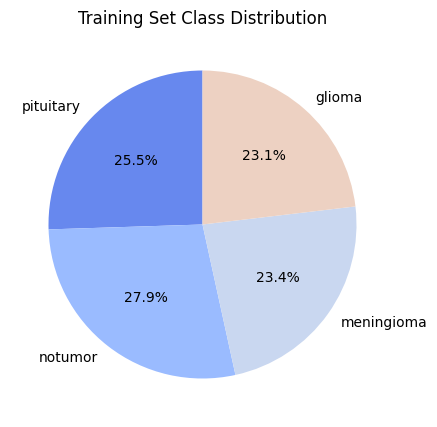

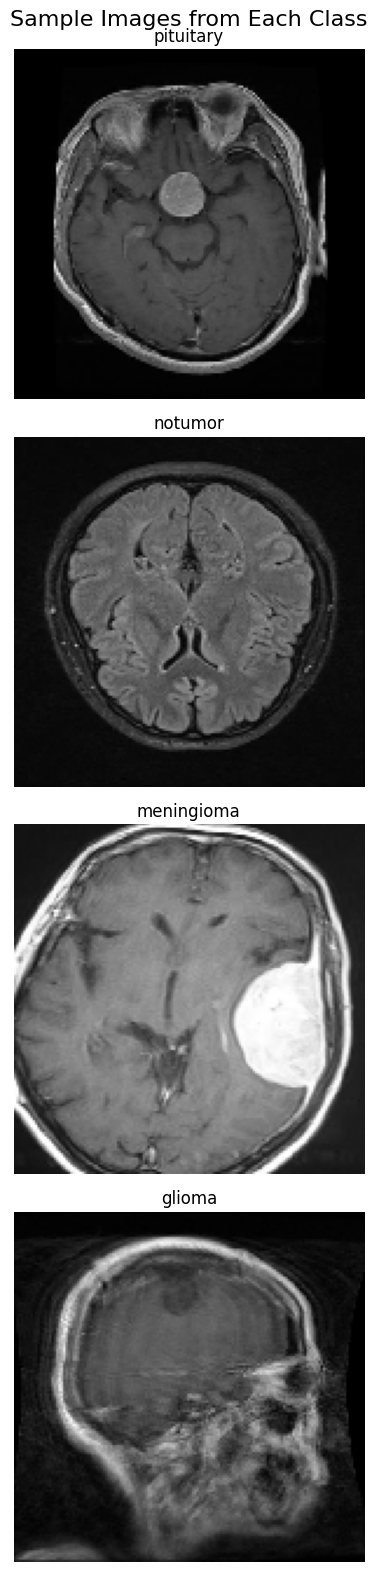

In [ ]:
# Define the datasets directory in path
train_data_dir = os.path.join(path, "Training")
test_data_dir = os.path.join(path, "Testing")

# Get class distribution
def class_distr(dir):
    class_counts = {}
    for class_name in os.listdir(dir):
        class_path = os.path.join(dir, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

# Plot class distribution
train_distr = class_distr(train_data_dir)
test_distr = class_distr(test_data_dir)

plt.figure(figsize=(5, 5))
plt.pie(train_distr.values(), labels=train_distr.keys(), autopct='%1.1f%%', startangle=90, colors=sns.color_palette("coolwarm"))
plt.title("Training Set Class Distribution")
plt.show()

# Function to display sample images from each class
def show_sample_img(dir, num_samp=1):
    classes = os.listdir(dir)
    plt.figure(figsize=(12, len(classes) * 4))

    for i, class_name in enumerate(classes):
        class_path = os.path.join(dir, class_name)
        if os.path.isdir(class_path):
            image_files = os.listdir(class_path)
            sample = random.sample(image_files, min(num_samp, len(image_files)))

            for j, img_file in enumerate(sample):
                img_path = os.path.join(class_path, img_file)
                img = load_img(img_path, target_size=(150, 150))
                img_array = img_to_array(img) / 255.0

                plt.suptitle("Sample Images from Each Class", fontsize=16)
                plt.subplot(len(classes), num_samp, i * num_samp + j + 1)
                plt.imshow(img_array)
                plt.title(class_name)
                plt.axis("off")
    plt.tight_layout()
    plt.show()

show_sample_img(train_data_dir)

# Data Preprocessing

## Data Augmentation and Preprocessing

Since medical image datasets are often limited in size and can have significant variability in terms of image quality, patient positioning, and tumor appearance.Data augmentation is primarily used here to increase the size and diversity of training dataset, which helps to improve the robustness and generalization ability of the CNN model.  It utilizes ImageDataGenerator to augment the training data with operations like rotation, shifting, shearing, zooming, and flipping

In [ ]:
# Data augmentation & preprocessing
train_gen = ImageDataGenerator(
    rescale=1./255,  # Normalization of pixel values
    rotation_range=20,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=(0.5, 1.2)
)

# Preprocessing of testing data
test_gen = ImageDataGenerator(rescale=1./255)


# Applying generator to both training and testing data
img_size = (192, 192) # Image parameter
batch_size = 32

# Training Data
train_generator = train_gen.flow_from_directory(
    train_data_dir,
    target_size= img_size,  # Resize images for CNN
    batch_size=batch_size,
    class_mode='categorical',
    seed = random.seed(42),
    subset='training'
)


test_generator = test_gen.flow_from_directory(
    test_data_dir,
    target_size= img_size,  # Resize images for CNN
    batch_size= batch_size,
    class_mode='categorical',
    seed = random.seed(42),
    shuffle = False
)

# Display label for each class
print("Training Class Labels:", train_generator.class_indices)
print("Testing Class Labels:", test_generator.class_indices)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Training Class Labels: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Testing Class Labels: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


## Calculating Class Weight

Class weight is calculated to address class imbalance.

First check the number of images in each class

In [ ]:
# Count images per class
class_lab = os.listdir(train_data_dir)
class_counts = {label: len(os.listdir(os.path.join(train_data_dir, label))) for label in class_lab}
print("Training Class distribution:", class_counts)

Training Class distribution: {'pituitary': 1457, 'notumor': 1595, 'meningioma': 1339, 'glioma': 1321}


Compute class weight since each class contains unequal number of images.

In [ ]:
# Get class indices and counts
class_indices = train_generator.class_indices
class_counts = np.bincount(train_generator.classes)

# Create a list of class indices weighted by their counts
w_class_indices = []
for class_index, count in enumerate(class_counts):
    w_class_indices.extend([class_index] * count)

# Calculate class weights
class_w = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)

# Convert class weights to a dictionary
class_w_dict = dict(enumerate(class_w))

print("Class Weight Dictionary:", class_w_dict)


Class Weight Dictionary: {0: 1.080999242997729, 1: 1.0664675130694548, 2: 0.8952978056426333, 3: 0.9800960878517502}


# Building a CNN Model

A Convolutional Neutral Network(CNN) was built by defining the architecture of the CNN model using the Sequential API from Keras. Convolutional layers, max pooling layers, flattening, dense layers, and dropout for regularization were included. The model is then compiled with an Adam optimizer, categorical cross-entropy loss, and accuracy metric. Finally, a summary of the model is printed.

In [ ]:
def build_brain_cnn(input_shape=(192, 192, 3), num_classes=4):
    model = Sequential()

    # Convolutional Block 1
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional Block 2
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional Block 3
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional Block 4
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Initialize the model
input_shape = (192, 192, 3)
num_classes = 4
model = build_brain_cnn(input_shape, num_classes)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model Summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 190, 190, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 95, 95, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 93, 93, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 44, 44, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 20, 20, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      13,107,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,498,180 (51.49 MB)

 Trainable params: 13,498,180 (51.49 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training and Evaluation



### Using CNN

Train the CNN model using the training and validation data generators. Specify the number of epochs, batch size, and use callbacks like EarlyStopping and ReduceLROnPlateau for better training control. Then, save trained model to a file.

In [ ]:
# Calculate steps_per_epoch and validation_steps
steps_per_epoch = train_generator.n // batch_size
validation_steps = test_generator.n // batch_size

# Early Stopping Configuration
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
    verbose=1
)

# Learning Rate Reduction Configuration
model_rlr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    cooldown=0,
    verbose=1
)
# Train the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=30,
    batch_size=batch_size,
    callbacks=[early_stopping, model_rlr],
    )

model.save('brain_cnn_model.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 93s 452ms/step - accuracy: 0.3901 - loss: 1.2609 - val_accuracy: 0.3509 - val_loss: 1.9682 - learning_rate: 0.0010
Epoch 2/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 64s 358ms/step - accuracy: 0.5175 - loss: 1.0684 - val_accuracy: 0.4211 - val_loss: 1.8444 - learning_rate: 0.0010
Epoch 3/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 91s 408ms/step - accuracy: 0.5927 - loss: 0.9192 - val_accuracy: 0.5843 - val_loss: 1.2207 - learning_rate: 0.0010
Epoch 4/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 70s 393ms/step - accuracy: 0.6453 - loss: 0.8442 - val_accuracy: 0.5645 - val_loss: 1.0714 - learning_rate: 0.0010
Epoch 5/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 62s 347ms/step - accuracy: 0.6758 - loss: 0.7796 - val_accuracy: 0.5576 - val_loss: 1.0465 - learning_rate: 0.0010
Epoch 6/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 63s 353ms/step - accuracy: 0.6906 - loss: 0.7395 - val_accuracy: 0.6697 - val_loss: 0.9764 - learning_rate: 0.0010
Epoch 7/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 70s 393ms/step - accuracy: 0.7

### Visualize Training Process

Visualize the training process by plotting the training and validation accuracy and loss curves over epochs. This helps to assess the model's performance and identify potential issues like overfitting.

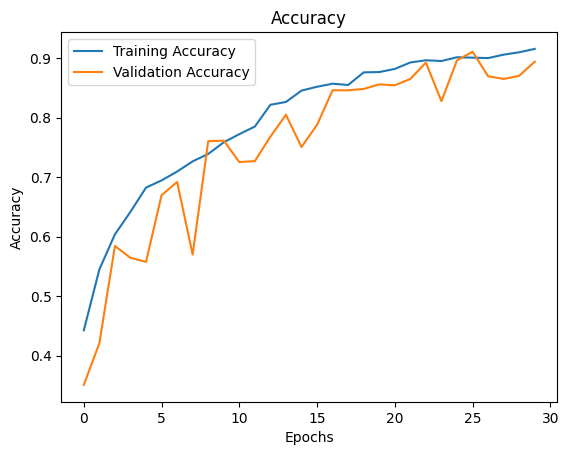

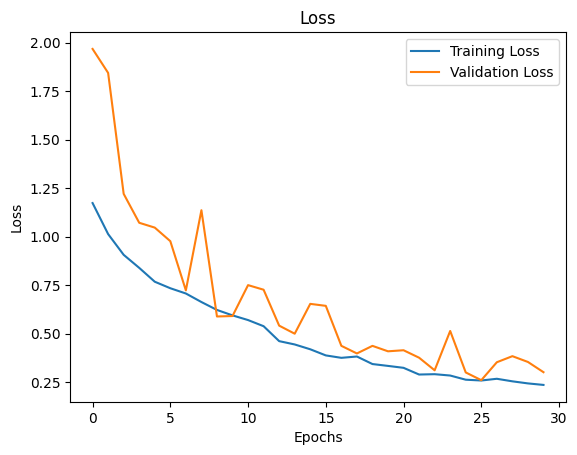

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### CNN Model Evaluation

Evaluate the performance of the trained model using Confusion Matrix Classification Report, and AUC-ROC

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step


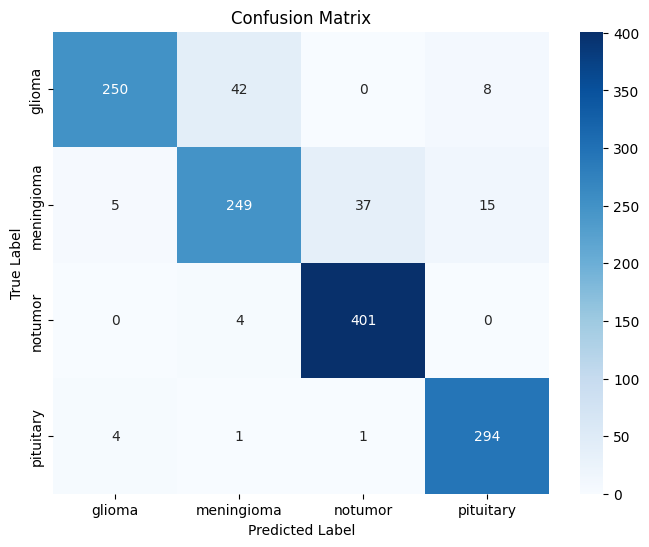

AUC-ROC: 0.9872036720123964

Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.83      0.89       300
  meningioma       0.84      0.81      0.83       306
     notumor       0.91      0.99      0.95       405
   pituitary       0.93      0.98      0.95       300

    accuracy                           0.91      1311
   macro avg       0.91      0.90      0.91      1311
weighted avg       0.91      0.91      0.91      1311



In [ ]:
# Get class labels from the test generator
class_names = list(train_generator.class_indices.keys())

# Predict on test data
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print accuracy, classification report, AUC-ROC
roc_auc = roc_auc_score(y_true, y_pred, multi_class="ovr")

print("AUC-ROC:", roc_auc)
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))



### Model Architecture

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


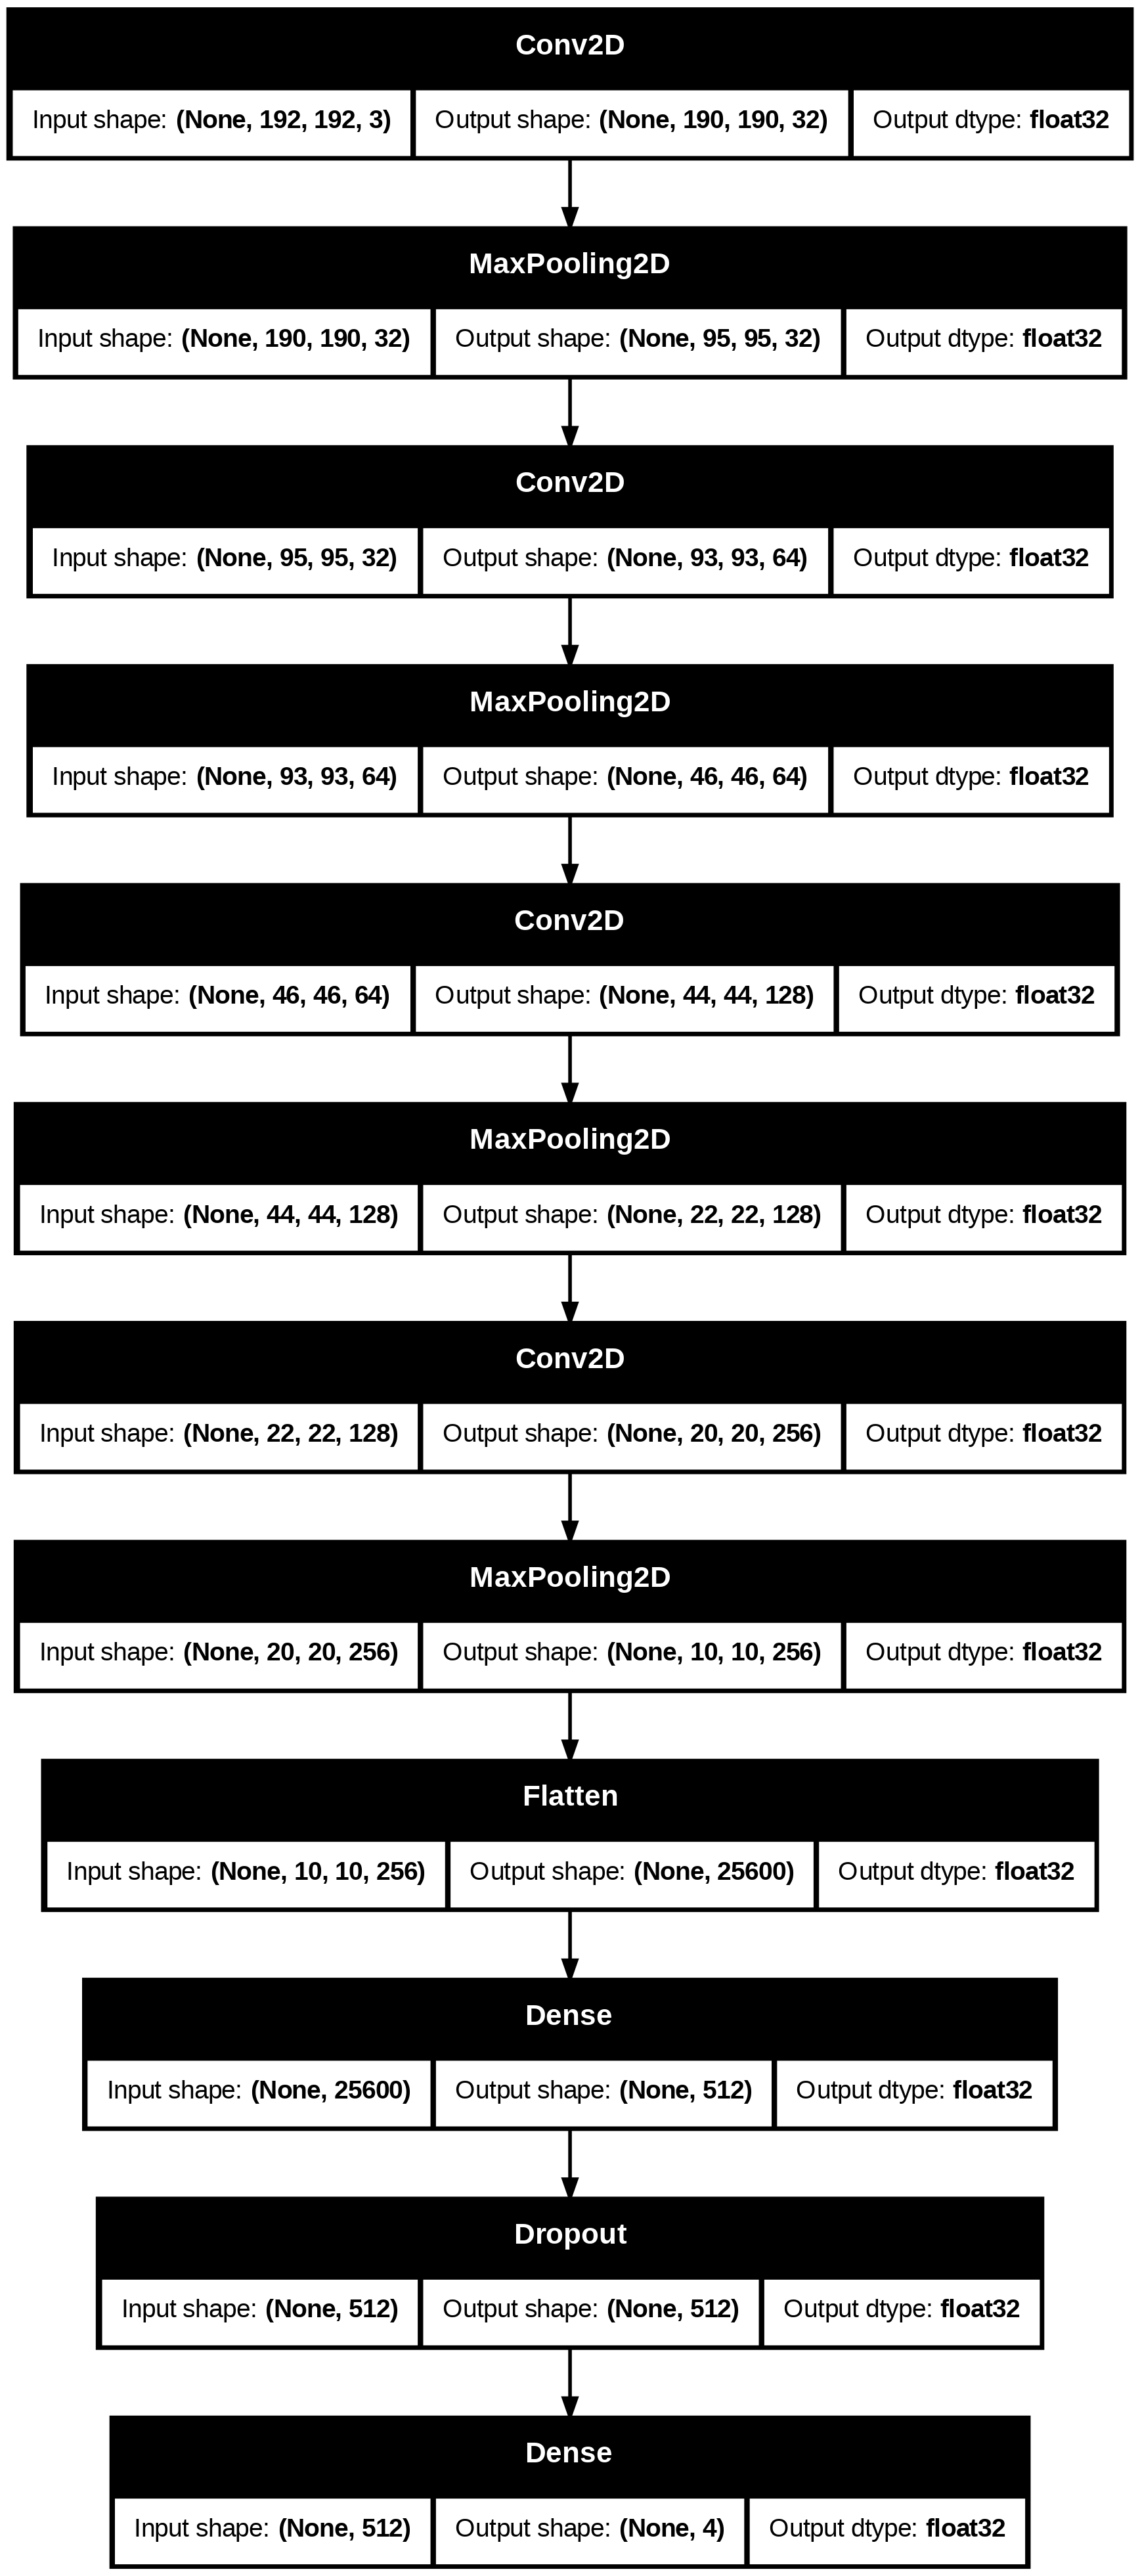

In [ ]:
model_arch = build_brain_cnn(input_shape=(192, 192, 3), num_classes=4) # Call the function directly
model_arch.set_weights(model.get_weights())  # Copy weights from the trained model

# Save model architecture to a file
plot_model(model_arch, show_dtype=True, to_file='brain_model_architecture.png', show_shapes=True)

# Display model architecture
Image(retina=True, filename='brain_model_architecture.png')

# Other ML Models

Compare the CNN model with some traditional machine learning models - SVM, Random Forest, and XGBoost. Extract features from the CNN model and then train these classifiers on the extracted features.

In [ ]:
# Extract features from the CNN for training traditional ML models
train_features = model.predict(train_generator)
test_features = model.predict(test_generator)

# Get true labels for training and testing
train_labels = train_generator.classes
test_labels = test_generator.classes

# SVM Model
svm_classifier = SVC(kernel='linear', probability=True, class_weight=class_w_dict)
svm_classifier.fit(train_features, train_labels)
svm_predictions = svm_classifier.predict(test_features)

# Random Forest Model
rf_classifier = RandomForestClassifier(n_estimators=80, random_state=42, class_weight=class_w_dict)
rf_classifier.fit(train_features, train_labels)
rf_predictions = rf_classifier.predict(test_features)

# XGBoost Model
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', scale_pos_weight=class_w_dict[1]/class_w_dict[0]) # Assuming binary classification
xgb_classifier.fit(train_features, train_labels)
xgb_predictions = xgb_classifier.predict(test_features)


# Evaluation
def evaluate_model(predictions, true_labels, model_name):
    print(f"--- {model_name} ---")
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='weighted', zero_division=0) #Handle zero division
    recall = recall_score(true_labels, predictions, average='weighted', zero_division=0) #Handle zero division
    f1 = f1_score(true_labels, predictions, average='weighted', zero_division=0) #Handle zero division

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")

    print("Classification Report:")
    print(classification_report(true_labels, predictions, target_names=class_names, zero_division=0)) #Handle zero division

    conf_mat = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(conf_mat)

    # Get prediction probabilities instead of class labels
    if model_name == "SVM":
        pred_probs = svm_classifier.predict_proba(test_features)
    elif model_name == "Random Forest":
        pred_probs = rf_classifier.predict_proba(test_features)
    elif model_name == "XGBoost":
        pred_probs = xgb_classifier.predict_proba(test_features)
    else:
        pred_probs = predictions

    try: #handle potential errors in roc_auc calculation
        roc_auc = roc_auc_score(true_labels, pred_probs, multi_class="ovr")
        print(f"AUC-ROC: {roc_auc}")
    except ValueError as e:
        print("AUC-ROC could not be computed: {e}")


    print("-" * 20)

evaluate_model(svm_predictions, test_labels, "SVM")
evaluate_model(rf_predictions, test_labels, "Random Forest")
evaluate_model(xgb_predictions, test_labels, "XGBoost")

179/179 ━━━━━━━━━━━━━━━━━━━━ 58s 323ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:32:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


--- SVM ---
Accuracy: 0.02440884820747521
Precision: 0.13491536721833622
Recall: 0.02440884820747521
F1-Score: 0.03669719721543334
Classification Report:
              precision    recall  f1-score   support

      glioma       0.02      0.02      0.02       300
  meningioma       0.55      0.07      0.13       306
     notumor       0.01      0.01      0.01       405
   pituitary       0.00      0.00      0.00       300

    accuracy                           0.02      1311
   macro avg       0.14      0.03      0.04      1311
weighted avg       0.13      0.02      0.04      1311

Confusion Matrix:
[[  6   0 294   0]
 [ 18  22 252  14]
 [  1  17   4 383]
 [293   1   6   0]]
AUC-ROC: 0.3889873753773967
--------------------
--- Random Forest ---
Accuracy: 0.2578184591914569
Precision: 0.25346423526164785
Recall: 0.2578184591914569
F1-Score: 0.25307310514727577
Classification Report:
              precision    recall  f1-score   support

      glioma       0.22      0.21      0.21       